Loading and preparing data...

Original column names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heartdisease']

Processed column names: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target', 'age_disc', 'trestbps_disc', 'chol_disc', 'thalach_disc', 'oldpeak_disc']

Generating visualizations...

Dataset Statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000

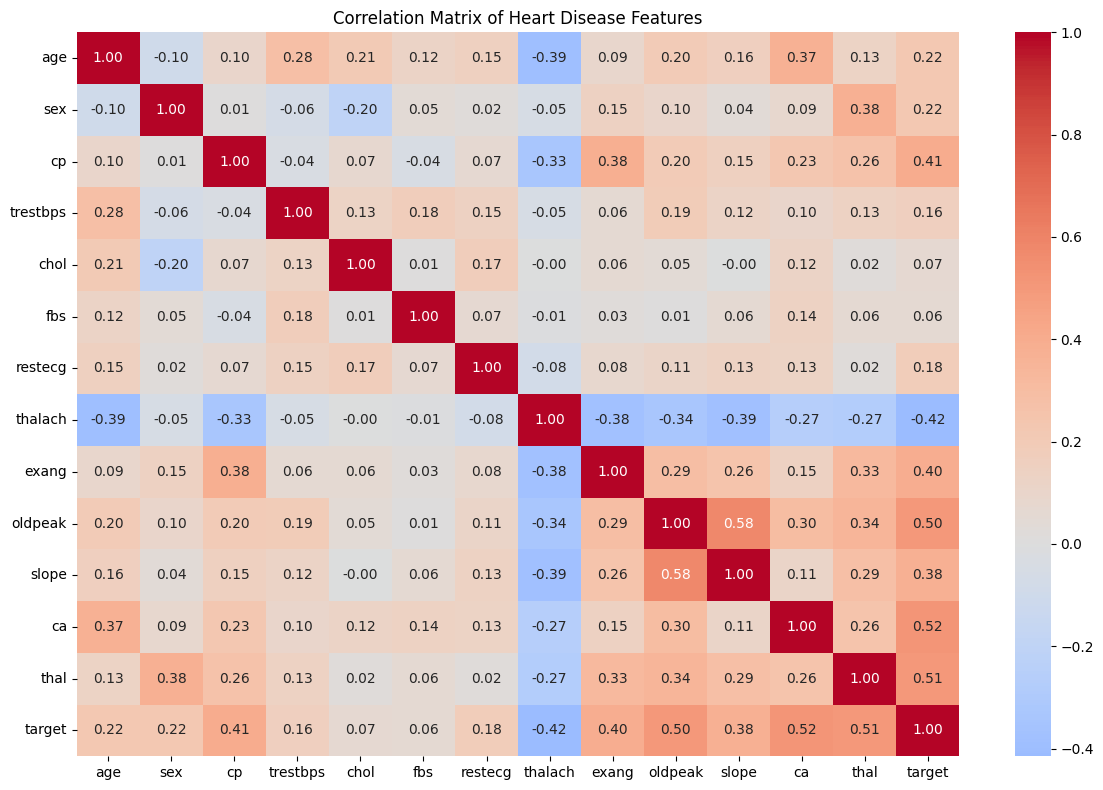

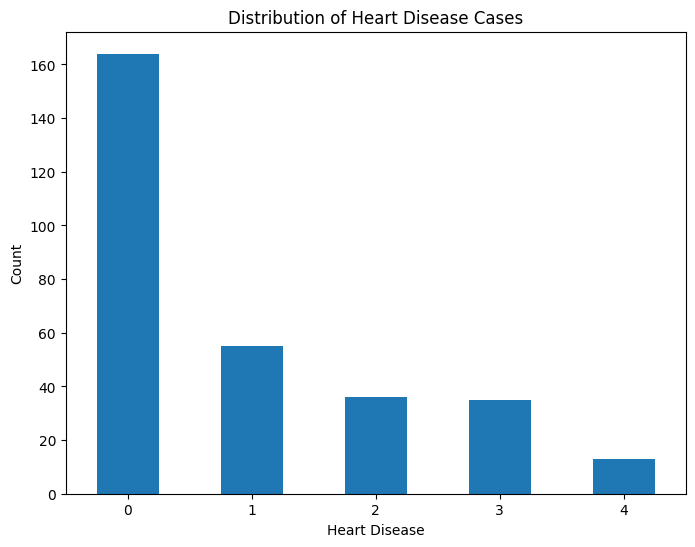

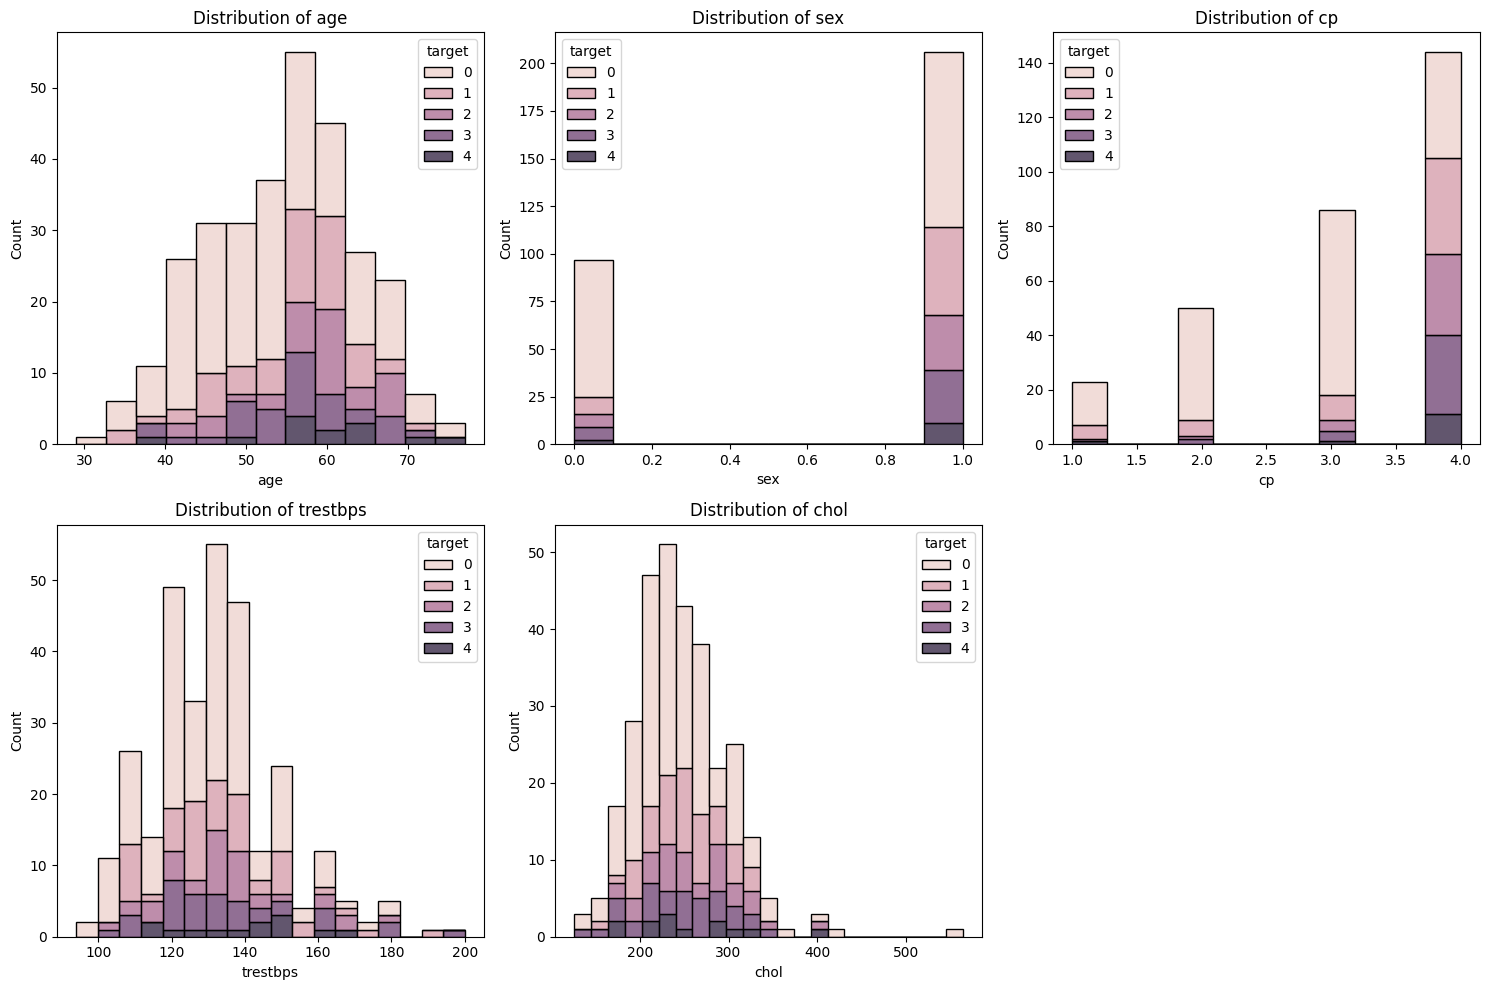


Creating and training Bayesian Network...
Model validation: True

Model Accuracy: 0.47540983606557374

Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.64        29
         1.0       0.00      0.00      0.00        12
         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         4

    accuracy                           0.48        61
   macro avg       0.10      0.20      0.13        61
weighted avg       0.23      0.48      0.31        61


Making sample prediction...

Probability Distribution for Heart Disease:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.2000 |
+-----------+---------------+
| target(1) |        0.2000 |
+-----------+---------------+
| target(2) |        0.2000 |
+-----------+---------------+
| target(3) |        0.2000 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [71]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(filepath):
    # Load the dataset
    df = pd.read_csv('/content/heart.csv')

    # Print column names to verify
    print("\nOriginal column names:", df.columns.tolist())

    # Check for possible target column names
    target_column = None
    possible_names = ['target', 'heartdisease', 'heart_disease', 'condition', 'diagnosis']
    for name in possible_names:
        if name in df.columns:
            target_column = name
            break

    if target_column is None:
        # If no standard name found, assume the last column is target
        target_column = df.columns[-1]
        print(f"\nAssuming last column '{target_column}' as target variable")

    # Replace '?' with NaN
    df = df.replace('?', np.nan)

    # Identify numeric and categorical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Remove target column from numeric/categorical lists if present
    if target_column in numeric_columns:
        numeric_columns.remove(target_column)
    if target_column in categorical_columns:
        categorical_columns.remove(target_column)

    # Convert categorical columns to numeric
    for col in categorical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing values
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Create copy for discretization
    df_discrete = df.copy()

    # Discretize continuous variables
    continuous_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    continuous_vars = [var for var in continuous_vars if var in df.columns]
    discretizer = {}

    for var in continuous_vars:
        discretizer[var] = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
        df_discrete[f'{var}_disc'] = discretizer[var].fit_transform(df[[var]]).astype(int)

    # Drop original continuous columns
    df_discrete = df_discrete.drop(continuous_vars, axis=1)

    # Rename target column to 'target' for consistency
    df = df.rename(columns={target_column: 'target'})
    df_discrete = df_discrete.rename(columns={target_column: 'target'})

    print("\nProcessed column names:", df_discrete.columns.tolist())

    return df, df_discrete, discretizer

def create_bayesian_network(columns):
    # Create edges for the Bayesian Network
    edges = []
    feature_columns = [col for col in columns if col != 'target']

    for feature in feature_columns:
        edges.append((feature, 'target'))

    # Define the structure of the Bayesian Network
    model = BayesianNetwork(edges)

    return model

def train_and_evaluate_model(model, data):
    # Split the data into train and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    # Train the model using Maximum Likelihood Estimation
    mle = MaximumLikelihoodEstimator(model=model, data=train_data)

    # Estimate CPDs for all nodes
    for node in model.nodes():
        cpd = mle.estimate_cpd(node)
        model.add_cpds(cpd)

    # Check if the model is valid
    print("Model validation:", model.check_model())

    # Evaluate the model
    predictions = []
    actual = []

    inference = VariableElimination(model)

    for idx, row in test_data.iterrows():
        evidence = row.drop('target').to_dict()
        prediction = inference.query(variables=['target'], evidence=evidence)
        pred_value = 1 if prediction.values[1] > prediction.values[0] else 0
        predictions.append(pred_value)
        actual.append(row['target'])

    # Calculate and print metrics
    accuracy = accuracy_score(actual, predictions)
    print("\nModel Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(actual, predictions))

    return model, accuracy

def visualize_data(df):
    # Display basic statistics
    print("\nDataset Statistics:")
    print(df.describe())

    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create correlation matrix heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Heart Disease Features')
    plt.tight_layout()
    plt.show()

    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    df['target'].value_counts().plot(kind='bar')
    plt.title('Distribution of Heart Disease Cases')
    plt.xlabel('Heart Disease')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

    # Distribution of numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'target'][:5]  # Select first 5 numeric columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df, x=col, hue='target', multiple="stack")
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

def predict_heart_disease(model, evidence_dict):
    inference = VariableElimination(model)
    result = inference.query(variables=['target'], evidence=evidence_dict)
    return result

def main():
    try:
        # Load and prepare data
        print("Loading and preparing data...")
        df_original, df_discrete, discretizer = load_and_prepare_data('/content/heart.csv')

        # Visualize data
        print("\nGenerating visualizations...")
        visualize_data(df_original)

        # Create and train the Bayesian Network
        print("\nCreating and training Bayesian Network...")
        model = create_bayesian_network(df_discrete.columns)
        trained_model, accuracy = train_and_evaluate_model(model, df_discrete)

        # Example prediction
        print("\nMaking sample prediction...")
        # Create sample evidence using actual columns from the processed dataset
        sample_evidence = {}
        for col in df_discrete.columns:
            if col != 'target':
                sample_evidence[col] = df_discrete[col].mode()[0]

        prediction = predict_heart_disease(trained_model, sample_evidence)
        print("\nProbability Distribution for Heart Disease:")
        print(prediction)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nPlease check the dataset structure and column names.")

if __name__ == "__main__":
    main()